## TRATAMIENTO DATASET

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14,9]

import collections
from PIL import Image

from fastai import *
from fastai.callbacks import *
from fastai.vision import *
from fastai.metrics import error_rate


import fastai
fastai.__version__

'1.0.54'

In [3]:
path = Path("IMÁGENES FILTRADAS/")

In [4]:
path.ls()

[PosixPath('IMÁGENES FILTRADAS/BURKITT_32.jpg'),
 PosixPath('IMÁGENES FILTRADAS/LLC_6.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_20.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_16.jpg'),
 PosixPath('IMÁGENES FILTRADAS/HCL_21.jpg'),
 PosixPath('IMÁGENES FILTRADAS/HCL_10.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_110.jpg'),
 PosixPath('IMÁGENES FILTRADAS/LLC_48.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_85.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_73.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_7.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_138.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_44.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_147.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_62.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_10.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_135.jpg'),
 PosixPath('IMÁGENES FILTRADAS/HCL_6.jpg'),
 PosixPath('IMÁGENES FILTRADAS/LCM_23.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_107.jpg'),
 PosixPath('IMÁGENES FILTRAD

In [5]:
fnames = get_image_files(path)
fnames[:10]

[PosixPath('IMÁGENES FILTRADAS/BURKITT_32.jpg'),
 PosixPath('IMÁGENES FILTRADAS/LLC_6.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_20.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_16.jpg'),
 PosixPath('IMÁGENES FILTRADAS/HCL_21.jpg'),
 PosixPath('IMÁGENES FILTRADAS/HCL_10.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_110.jpg'),
 PosixPath('IMÁGENES FILTRADAS/LLC_48.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_85.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_73.jpg')]

In [6]:
pat = r'/([^/]+)_\d+.jpg$'

In [7]:
data = ImageDataBunch.from_name_re(path, fnames, pat, ds_tfms=get_transforms(), size=363).normalize(imagenet_stats)

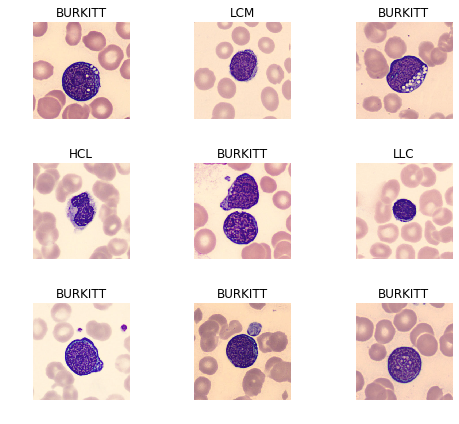

In [8]:
data.show_batch(rows=3, figsize=(7,6))

In [9]:
train = data.train_ds
valid = data.valid_ds
# train.to_csv(dest='/shared/TFG_marc/prueba.csv')

In [10]:
df= pd.concat([train.to_df(),valid.to_df()], ignore_index=False)
df.head()

,x,y
0,BURKITT_32.jpg,BURKITT
1,FOLICULAR_20.jpg,FOLICULAR
2,HCL_21.jpg,HCL
3,HCL_10.jpg,HCL
4,FOLICULAR_110.jpg,FOLICULAR


In [11]:
df.columns=['Image','Id']
df.head()

,Image,Id
0,BURKITT_32.jpg,BURKITT
1,FOLICULAR_20.jpg,FOLICULAR
2,HCL_21.jpg,HCL
3,HCL_10.jpg,HCL
4,FOLICULAR_110.jpg,FOLICULAR


In [12]:
print(data.classes)

['BURKITT', 'FOLICULAR', 'HCL', 'LCM', 'LLC']


In [13]:
len(data.classes),data.c

(5, 5)

In [14]:
df['Id'].value_counts()[:5]

BURKITT      188
FOLICULAR    149
LCM           59
LLC           57
HCL           48
Name: Id, dtype: int64

In [15]:
df['target'] = 1
df1 = df.copy()
df['target'] = 0
df = df.append(df1)
target_col = 2

In [16]:
df.head()

,Image,Id,target
0,BURKITT_32.jpg,BURKITT,0
1,FOLICULAR_20.jpg,FOLICULAR,0
2,HCL_21.jpg,HCL,0
3,HCL_10.jpg,HCL,0
4,FOLICULAR_110.jpg,FOLICULAR,0


In [17]:
df.shape

(1002, 3)

## ITEMBASE Y ITEMLIST

In [18]:
mean, std = torch.tensor(imagenet_stats)

class SiamImage(ItemBase):
    def __init__(self, img1, img2): 
        self.img1, self.img2 = img1, img2
        self.obj, self.data = (img1, img2), [(img1.data-mean[...,None,None])/std[...,None,None], (img2.data-mean[...,None,None])/std[...,None,None]]
    def apply_tfms(self, tfms,*args, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, *args, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, *args, **kwargs)
        self.data = [(self.img1.data-mean[...,None,None])/std[...,None,None], (self.img2.data-mean[...,None,None])/std[...,None,None]]
        return self
    def __repr__(self): return f'{self.__class__.__name__} {self.img1.shape, self.img2.shape}'
    def to_one(self):
        return Image(mean[...,None,None]+torch.cat(self.data,2)*std[...,None,None])

In [19]:
class SiamImageItemList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __len__(self)->int: return len(self.items) or 1 

    def get(self, i):
        match=1
        if i>=len(self.items)//2:
            match = 0
        fn = self.items[i]
        img1 = super().get(i) 

        imgs = self.inner_df.Image.values
        ids = self.inner_df.Id.values
        wcls = ids[i]
        simgs = imgs[ids == wcls]
        dimgs = imgs[ids != wcls]
        if len(simgs)==1 and match==1:
            fn2=fn
        else:
            while True:
                np.random.shuffle(simgs)
                np.random.shuffle(dimgs)
                if simgs[0] != fn:
                    fn2 = [simgs[0] if match==1 else dimgs[0]][0]
                    break
            fn2 = self.items[np.where(imgs==fn2)[0][0]]
        img2 = super().open(fn2) 
        return SiamImage(img1, img2)

    def reconstruct(self, t): return SiamImage(mean[...,None,None]+t[0]*std[...,None,None], mean[...,None,None]+t[1]*std[...,None,None])

    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(9,10), **kwargs):
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()
        

In [20]:
whl_tfms = get_transforms()
bs = 8

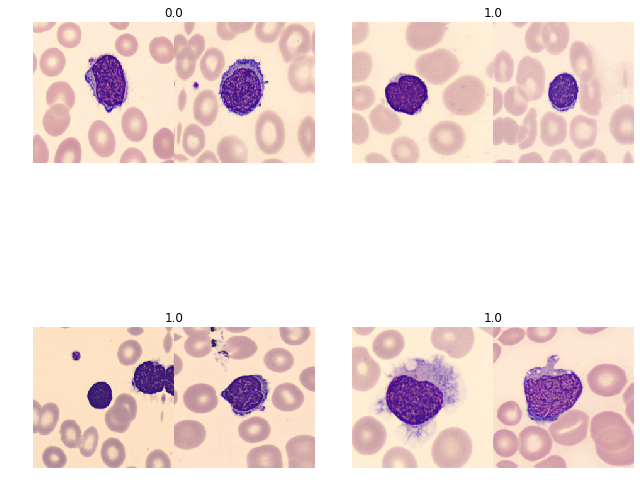

In [21]:
data = (SiamImageItemList.from_df(df=df, path=path, cols=0)
         .split_by_rand_pct(valid_pct=0.2, seed=34)
         .label_from_df(cols=target_col, label_cls=FloatList)
         .transform(whl_tfms, size=224)
         .databunch(bs=bs))

data.show_batch(2)

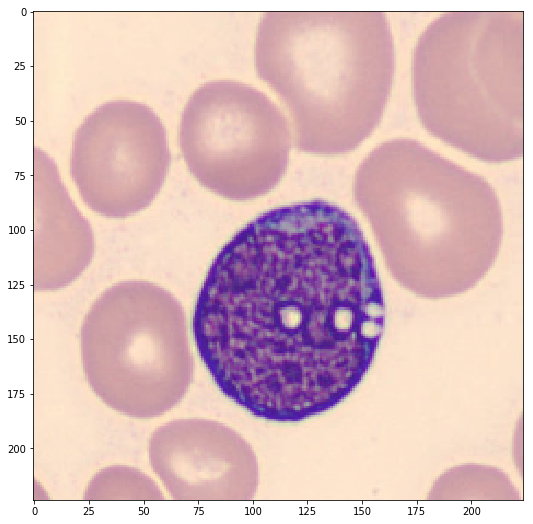

In [22]:
x = next(iter(data.train_dl))
t=x[0][0][0].cpu()
to = mean[...,None,None] + t* std[...,None,None]
import torchvision
ti = torchvision.transforms.ToPILImage(to)
plt.imshow(to.numpy().transpose(1,2,0))

## SNN Y LOSS FUNCTION

In [23]:
from fastai.vision import learner

class SiameseNet(nn.Module):
    def __init__(self, arch=models.resnet50, lin_ftrs=[256, 128], emb_sz=128,ps=0.5, bn_final=False):
        super(SiameseNet, self).__init__()
        self.arch, self.emb_sz = arch, emb_sz
        self.lin_ftrs, self.ps, self.bn_final = lin_ftrs, ps, bn_final
        self.body = learner.create_body(self.arch, True, learner.cnn_config(self.arch)['cut'])
        self.head = learner.create_head(num_features_model(self.body) * 1, self.emb_sz, self.lin_ftrs, self.ps,self.bn_final)
        self.cnn = nn.Sequential(self.body, self.head)

    def forward(self, x1, x2):
        output1 = self.cnn(x1)
        output2 = self.cnn(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.cnn(x)

In [24]:
class ContrastiveLoss(nn.Module):

    def __init__(self, margin=5.):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, ops, target, size_average=True):
        op1, op2 = ops[0], ops[1]
        dist = F.pairwise_distance(op1, op2)
        pdist = dist*target
        ndist = dist*(1-target)
        loss = 0.5* ((pdist**2) + (F.relu(self.margin-ndist)**2))
        return loss.mean() if size_average else losses.sum()

## INSTANCIAR EL MODELO

In [25]:
model = SiameseNet().cuda()
apply_init(model.head, nn.init.kaiming_normal_)
loss_func=ContrastiveLoss().cuda()
siam_learner = Learner(data, model, loss_func=loss_func, model_dir=Path(os.getcwd()) ) 

In [26]:
siam_learner.model

SiameseNet(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kerne

In [28]:
siam_learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,10.714017,10.591370,00:12
1,9.737941,12.037616,00:12
2,9.505132,11.133039,00:12
3,9.577903,11.615798,00:12
4,9.431245,10.994203,00:12


In [29]:
siam_learner.save('stage-1')

In [30]:
siam_learner.unfreeze()

In [31]:
siam_learner.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,9.552506,10.530913,00:12


In [32]:
siam_learner.load('stage-1');

/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ContrastiveLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type SiameseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [33]:
siam_learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


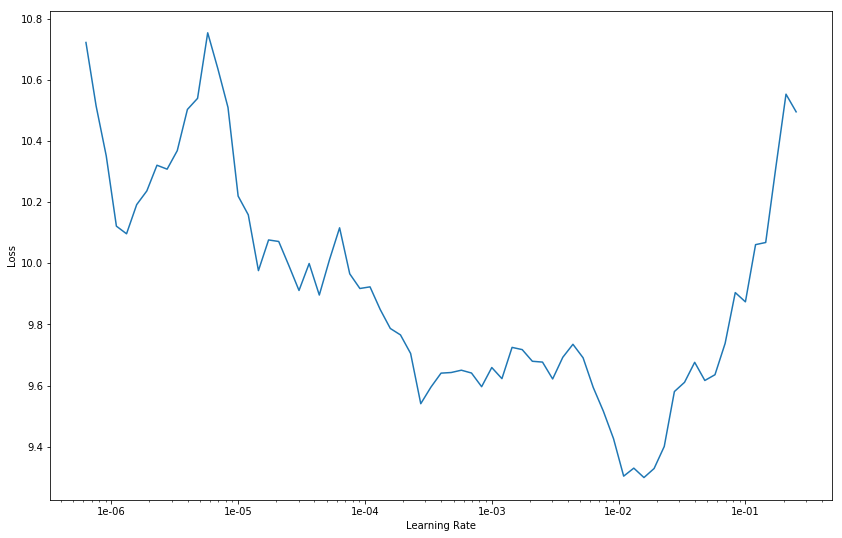

In [34]:
siam_learner.recorder.plot()

In [40]:
siam_learner.fit_one_cycle(5, slice(3e-5))

epoch,train_loss,valid_loss,time
0,9.386072,11.421229,00:12
1,9.552289,11.376604,00:12
2,9.575787,11.353097,00:12
3,9.550577,11.396743,00:12
4,9.494743,11.387245,00:13


In [41]:
siam_learner.save('stage-2')

In [42]:
def extract_embedding(dl, ds, mdl):
    mdl.eval()
    with torch.no_grad():
        preds = torch.zeros((len(ds), 128))
        start=0
        for cnt, (x, y) in enumerate(dl, start=0):
            size = x[0].shape[0]
            preds[start:start+size,:] = model.get_embedding(x[0])
            start+= size
        return preds

In [43]:
data = (SiamImageItemList.from_df(df=df, path=path, cols=0)
         .split_by_rand_pct(valid_pct=1, seed=34)
         .label_from_df(cols=target_col, label_cls=FloatList)
         .transform(whl_tfms, size=224)
         .databunch(bs=4))

/opt/conda/envs/fastai/lib/python3.6/site-packages/fastai/data_block.py:451: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


In [44]:
dl = data.valid_dl
ds = data.valid_ds
res = extract_embedding(dl, ds, model)

In [45]:
res.numpy().shape

(1002, 128)

In [46]:
whlc= np.array([df.loc[df.Image == Path(i.split(sep='/')[1]), 'Id'].values[0] for i in ds.items])

In [47]:
res.shape

torch.Size([1002, 128])

In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [53]:
pca.fit(res)
embs2d = pca.transform(res)

In [54]:
import colorsys
def random_colors(N, bright=True):
    
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def plot_embeddings(embeddings=None,whlc=None, xlim=None, ylim=None):

    plt.figure(figsize=(10,10))
    for cnt, i in enumerate(set(whlc)):

        inds = np.where(whlc==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[cnt])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(set(whlc))

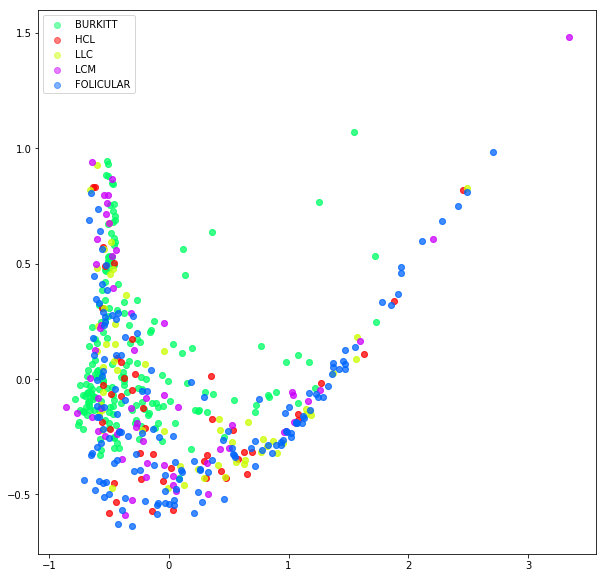

In [55]:
colors = random_colors(len(set(whlc)))
plot_embeddings(embs2d,whlc, xlim=None, ylim=None)

In [56]:
features = pd.DataFrame(res.numpy())
features['label'] = whlc
features.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,-0.067131,-0.048574,-0.089186,-0.064851,0.013695,0.021063,-0.046280,0.018555,-0.046452,-0.013827,...,0.000105,0.039498,-0.016441,0.151781,0.016132,0.026102,0.046141,-0.024234,0.039837,FOLICULAR
1,-0.056449,-0.092266,-0.215259,0.165158,-0.136524,0.062493,-0.010996,0.005147,-0.058299,-0.038543,...,-0.108541,0.213489,-0.007371,0.044536,0.022609,0.003213,-0.060560,-0.085505,0.003063,FOLICULAR
2,-0.139243,-0.040081,-0.099637,0.011485,-0.055418,0.011487,-0.043550,0.002753,0.005126,-0.071916,...,-0.055357,0.079764,-0.037375,0.139699,-0.023655,0.010342,-0.002030,-0.009239,0.015550,LCM
3,-0.061816,-0.073397,-0.149521,0.215377,-0.110047,0.031121,0.048951,0.021566,-0.011582,-0.047866,...,-0.062143,0.233443,-0.003788,0.046088,0.020901,-0.004748,-0.075737,-0.037556,-0.023505,LLC
4,0.004776,-0.078963,-0.133113,0.308288,-0.075434,-0.005310,0.119372,0.056849,-0.032297,-0.061515,...,-0.021099,0.294515,0.020730,-0.050701,0.028867,0.010783,-0.078795,-0.045000,-0.028575,FOLICULAR


In [57]:
features.shape

(1002, 129)

In [58]:
def oneshot(model,img1,img2):
    output1,output2 = model(img1.cuda(),img2.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    return euclidean_distance

In [59]:
df_original = df1.reset_index(drop=True)
df_original.head()

,Image,Id,target
0,BURKITT_32.jpg,BURKITT,1
1,FOLICULAR_20.jpg,FOLICULAR,1
2,HCL_21.jpg,HCL,1
3,HCL_10.jpg,HCL,1
4,FOLICULAR_110.jpg,FOLICULAR,1


In [60]:
df_original

,Image,Id,target
0,BURKITT_32.jpg,BURKITT,1
1,FOLICULAR_20.jpg,FOLICULAR,1
2,HCL_21.jpg,HCL,1
3,HCL_10.jpg,HCL,1
4,FOLICULAR_110.jpg,FOLICULAR,1
5,FOLICULAR_85.jpg,FOLICULAR,1
6,BURKITT_73.jpg,BURKITT,1
7,BURKITT_138.jpg,BURKITT,1
8,FOLICULAR_44.jpg,FOLICULAR,1
9,FOLICULAR_147.jpg,FOLICULAR,1


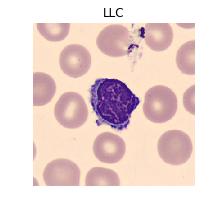

In [173]:
im1 = open_image( path / df_original.Image[491])
im1.show()
plt.title(df_original.Id[491])
plt.show()


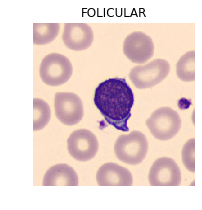

In [178]:
im2 = open_image( path / df_original.Image[488])
im2.show()
plt.title(df_original.Id[488])
plt.show()

In [179]:
oneshot(siam_learner.model, im1.resize(224).data[None,:,:,:], im2.resize(224).data[None,:,:,:])

tensor([0.0244], device='cuda:0', grad_fn=<NormBackward1>)

In [82]:
def obtenervector(im1, im2, mdl):
    mdl.eval()
    with torch.no_grad():
        out1, out2 = mdl(im1,im2)
        return out1, out2

In [83]:
c=0
for cnt, (x, y) in enumerate(dl, start=0):
    c = c+1
    o1,o2 = model(x[0],x[1])
    v = x[0]
    if c == 1:
        break
   

In [84]:
oneshot(siam_learner.model, v[[2]], v[[1]])

tensor([0.8574], device='cuda:0', grad_fn=<NormBackward1>)

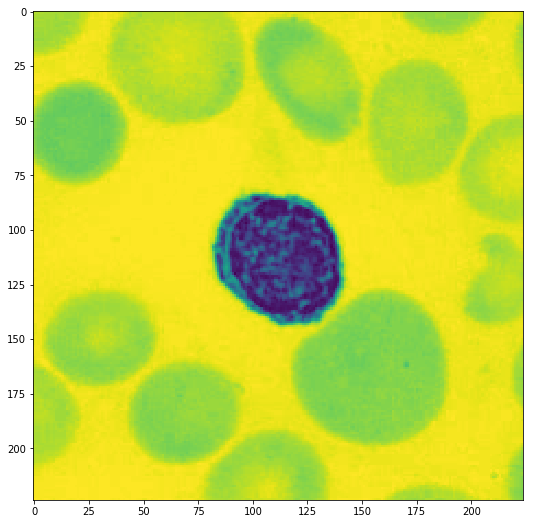

In [77]:
plt.imshow(v.cpu().numpy()[3][0])


In [78]:
oneshot(siam_learner.model, im1.resize(224).data[None,:,:,:], im2.resize(224).data[None,:,:,:])

tensor([0.1096], device='cuda:0', grad_fn=<NormBackward1>)

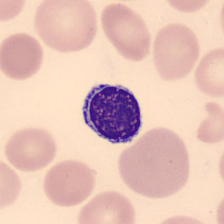

In [103]:
im1.resize(224)